# Histogram of Oriented Gradients
- Used to quantify *texture* and *shape*.
- Refer [HOG paper](https://gurus.pyimagesearch.com/wp-content/uploads/2015/05/dalal_2005.pdf)
- The paper proposes a 5-stage descriptor to classify humans in still images.
    - Normalize the image prior to description
    - Computing gradients in both x and y directions
    - Obtaining weighted votes in spatial and orientation cells
    - Contrast normalizing overlapping spatial cells
    - Collecting all histograms of oriented gradients to form final feature vector.
- Important parameters are *orientations*, *pixels_per_cell*, *cells_per_block*. These three along with size of input image control dimensionality of resulting feature vector.
- The HOG is used in conjunction with a Linear SVM to perform object detection. 


## Step1 : Normalizing the image prior to description
- Three main normalization methods:
    - Gamma/power law: Take $log(p)$ of each pixel $p$ in input image.
    - Square-root norm: Take $\sqrt(p)$ of each pixel $p$.
    - Variance norm: Normalize each pixel by $p'=(p-\mu)/\sigma$ where $\mu$ and $\sigma$ and mean and variance of pixels in the image.

## Step 2: Gradient computation
- Compute image gradient in both x and y direction ([1.10.1](https://gurus.pyimagesearch.com/topic/gradients/))
- Gradient images are obtained by following eq:
$$
G_x = I*D_x
$$
and 
$$
G_y = I*D_y
$$
- Gradient magnitude is:
$$|G| = \sqrt(G_x^2 + G_y^2)$$
- Orientation of gradient for each pixel in input image is:
$$ \theta = arctan2(G_y,G_x) $$

## Step 3:
- Divide image into cells and blocks.
- A cell is square region defined by number of pixels that belong in each cell. If we had $128x128$ image and defined our *pixels_per_cell* ass $4x4$, we would have $32x32=1024$ cells
- For each cell we compute histogram of oriented gradiented using gradient magnitude and orientation as given in Step 2
- The number of orientations  control the number of bins in the resulting histogram. The gradient angle is either within the range $[0, 180] $(unsigned) or $[0, 360]$ (signed). In general, it’s preferable to use unsigned gradients in the range $[0, 180]$ with orientations  somewhere in the range $[9, 12]$. 
- Each pixel contributes a weighted vote to the histogram - **the weight of the vote is simply the gradient magnitude $|G|$ at the given pixel**.

## Step 4:
- To account for changes in illumination and contrast, we can normalize the gradient values locally, by grouping cells into blocks. 
- These blocks can overlap, meaning each cell contributes to final feature vector more than once.
- For each of the cells in current block we concat the corresponding gradient histograms by L1 or L2 normalize it.
- Performing this type of normalization implies that each of the cells will be represented in the final feature vector multiple times but normalized by a different value, which increases performance of the descriptor.

In [1]:
import sys
sys.path.append("../")

In [2]:
from skimage import exposure
from skimage import feature
import cv2
from cv_imshow import create_subplot, display_image
from imutils import paths, grab_contours, auto_canny
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

In [3]:
args = {
    "image1":"../images/florida_trip.png",
    "training":"../images/hog/training",
    "testing":"../images/hog/testing"
}

## Exercise
- Identifying car logos using HOG.
- Steps
    - Extract HOG features from our training set to characterize and quantify each car logo
    - Train ML model to distinguish each car logo
    - Apply classifier to recognize new, unseen car logos

In [4]:
print("[INFO] extracting features...")
data = []
labels = []

#loop over images in training set
for imagePath in paths.list_images(args["training"]):
    #extract make of car
    make = imagePath.split("/")[-2]
    
    #load the image, convert it to grayscale and detect edges.
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = auto_canny(gray)
    
    #find contours in the edge map, keeping only largest once
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    #extract logo and resize to common w and h
    (x,y,w,h) = cv2.boundingRect(c)
    logo = gray[y:y+h, x:x+w]
    logo = cv2.resize(logo, (200,100))
    
    #extract hog from logo
    H = feature.hog(logo, orientations=9, pixels_per_cell=(10,10),
                   cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
    
    #update the data and labels
    data.append(H)
    labels.append(make)

#train the KNN
print("[INFO] training classifier...")
model = KNeighborsClassifier(n_neighbors=1)
model.fit(data, labels)
print("[INFO] evaluating")

[INFO] extracting features...
[INFO] training classifier...
[INFO] evaluating


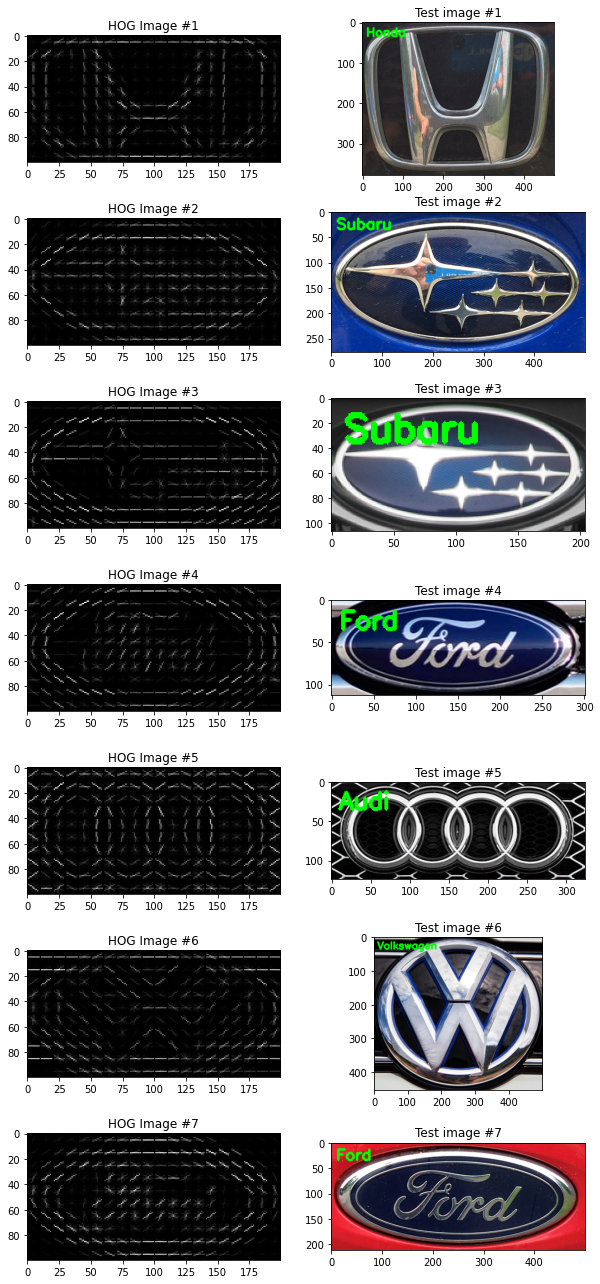

In [5]:
fig = plt.figure(figsize=(10,23))
rows = 7
columns = 2
for (i, imagePath) in enumerate(paths.list_images(args["testing"])):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    logo = cv2.resize(gray, (200,100))
    
    #extract HOG from test image and predict the make of car
    (H, hogImage) = feature.hog(logo, orientations=9, pixels_per_cell=(10,10),
                               cells_per_block=(2,2), transform_sqrt=True, block_norm="L1", visualize=True)
    pred = model.predict(H.reshape(1,-1))[0]
    
    #visualize hog image
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0,255))
    hogImage = hogImage.astype("uint8")
    create_subplot(fig, rows, columns, 2*i+1, "HOG Image #{}".format(i+1), hogImage)
    
    cv2.putText(image, pred.title(), (10,35), cv2.FONT_HERSHEY_SIMPLEX, 1.0, 
               (0,255,0), 3)
    create_subplot(fig, rows, columns, 2*i+2, "Test image #{}".format(i+1), image)